### CNN training for astrocyte body identification

*Step (a1) of the block diagram in the methods section

In [ ]:
# Initial imports and device setting
from pathlib import Path
from functools import partial
import os
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import dataloader as torch_dataloader
import imgaug.augmenters as iaa

from torchtrainer.imagedataset import ImageSegmentationDataset
from torchtrainer import img_util
from torchtrainer import transforms
from torchtrainer.models.resunet import ResUNet
from torchtrainer.learner import Learner
from torchtrainer import perf_funcs

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
# Data management functions
def name_2_label_map(img_filename):   
    '''Translates image name to binary label name.'''

    return img_filename.split('.')[0] + '.png'

def get_train_val_files(img_dir, val_split, ages_to_use, seed=None):
    '''Split the files into train and validation.'''
    
    if seed is not None:
        random.seed(seed)

    ages_dict = {}
    for file in os.listdir(img_dir):
        filename = file
        age = file.split('@')[0]
        if age in ages_dict and age in ages_to_use:
            ages_dict[age].append(filename)
        else:
            ages_dict[age] = [filename]

    val_files = []
    train_files = []
    for age, files in ages_dict.items():

        num_val_files = int(len(files)*val_split)
        age_val_files = random.sample(files, num_val_files)
        age_train_files = filter(lambda x: x not in age_val_files, files)
        val_files += age_val_files
        train_files += age_train_files  

    return train_files, val_files

In [10]:
#Parameters

root_dir = Path('Astrocytes samples/')
img_dir = root_dir/'selected samples'              # Original images
label_dir = root_dir/'selected samples - labels'   # Manually annotated images

params = {
            'size':(384, 384),   # Image size
            'batch_size':5,   
            'val_split':0.2,
            'epochs':100,
            'lr':0.001,
            'channel':None,           # If None, use all channels
         }

In [15]:
# Create dataloaders

val_split = params['val_split']
ages_to_use = ['P0', 'P5', 'P7', 'P14', 'P21']
train_files, val_files = get_train_val_files(img_dir, val_split, ages_to_use)

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=params['channel'])
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)

# Image transformations for data augmentation
imgaug_seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=[1, 2]),
    iaa.OneOf([
        iaa.GammaContrast(gamma=(0.5, 1.7)),
        iaa.pillike.EnhanceBrightness(factor=(0.5, 2.)),
        iaa.pillike.EnhanceContrast(factor=(0.5, 2.))
        ]),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0, 20)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Crop(px=(0, 20))
])
transform_funcs = transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)
transform_train =  transform_funcs + [transforms.TransfWhitten([28.095], [26.230])]   # Average and standard deviation calculated for the data
transform_valid = [transforms.TransfToTensor(), transforms.TransfWhitten([28.095], [26.230])]  

# Create ImageDataset instance
train_ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map=name_2_label_map, filename_filter=train_files,
                                   img_opener=img_opener_partial, label_opener=label_opener_partial, 
                                   transforms=transform_train)
valid_ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map=name_2_label_map, filename_filter=val_files,
                                   img_opener=img_opener_partial, label_opener=label_opener_partial, 
                                   transforms=transform_valid)

train_dl = torch_dataloader.DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=params['batch_size'], shuffle=False)

In [ ]:
# Train the network

%%time
loss_func = perf_funcs.DiceLossRaw()

model = ResUNet(num_channels=1, num_classes=2) 
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=params['lr'], epochs=params['epochs'], 
                                                steps_per_epoch=len(train_dl), pct_start=0.9)

learner = Learner(model, loss_func, optimizer, train_dl, valid_dl, scheduler, 
                       perf_funcs=perf_funcs.build_segmentation_accuracy_dict(), main_perf_func='f1',
                       scheduler_step_epoch=False)
learner.fit(params['epochs'])

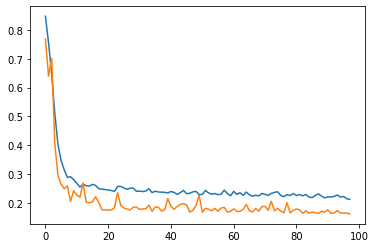

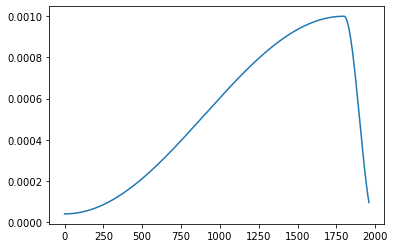

In [10]:
# Plot loss
plt.figure()
plt.plot(learner.train_loss_history)
plt.plot(learner.valid_loss_history)

plt.figure()
plt.plot(learner.lr_history)